In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
baseline_df = pd.read_json("evals/frame_reduction/mvbench_baseline.json")


In [3]:
baseline_df.groupby("category")["token_count"].sum(), baseline_df.groupby("category")["correct"].mean()

(category
 Action Antonym               226266
 Action Count                1134426
 Action Localization          943506
 Action Prediction            797220
 Action Sequence              656610
 Character Order             1398102
 Counterfactual Inference     309600
 Egocentric Navigation        406092
 Episodic Reasoning          1616886
 Fine-grained Action          165378
 Moving Attribute             309600
 Moving Count                 309600
 Moving Direction             309600
 Object Existence             309600
 Object Interaction           917448
 Object Shuffle              1233240
 Scene Transition            1032000
 State Change                1319154
 Unexpected Action           1253106
 Name: token_count, dtype: int64,
 category
 Action Antonym              0.780
 Action Count                0.455
 Action Localization         0.490
 Action Prediction           0.580
 Action Sequence             0.685
 Character Order             0.760
 Counterfactual Inference    0.47

In [4]:
scenecuts = [40, 80, 100, 120, 160]
scenecut_df = None
for sc in scenecuts:
    df = pd.read_json(f"evals/frame_reduction/mvbench_sc={sc}.json")
    df["scenecut"] = sc
    if scenecut_df is None:
        scenecut_df = df
    else:
        scenecut_df = pd.concat([scenecut_df, df])

In [5]:
scenecut_df.groupby(["scenecut", "category"])["token_count"].sum()

scenecut  category           
40        Action Antonym         140868
          Action Count           587982
          Action Localization    491490
          Action Prediction      414090
          Action Sequence        344946
                                  ...  
160       Object Interaction     676218
          Object Shuffle         920544
          Scene Transition       818634
          State Change           956406
          Unexpected Action      940926
Name: token_count, Length: 95, dtype: int64

In [6]:
def agg_stats(group):
    return pd.Series(
        [group.correct.mean(), group.token_count.sum()],
        index=["correct", "token_count"]
    )

In [7]:
baseline_agg = baseline_df.groupby("category")[["correct", "token_count"]].apply(agg_stats)
sc_agg = scenecut_df.groupby(["scenecut", "category"])[["correct", "token_count"]].apply(agg_stats)

In [8]:
baseline_agg

,correct,token_count
category,,
Action Antonym,0.780,226266.0
Action Count,0.455,1134426.0
Action Localization,0.490,943506.0
Action Prediction,0.580,797220.0
Action Sequence,0.685,656610.0
Character Order,0.760,1398102.0
Counterfactual Inference,0.470,309600.0
Egocentric Navigation,0.365,406092.0
Episodic Reasoning,0.645,1616886.0


In [9]:
sc_agg

correct  token_count
scenecut category                                 
40       Action Antonym         0.780     140868.0
         Action Count           0.380     587982.0
         Action Localization    0.495     491490.0
         Action Prediction      0.590     414090.0
         Action Sequence        0.680     344946.0
...                               ...          ...
160      Object Interaction     0.780     676218.0
         Object Shuffle         0.335     920544.0
         Scene Transition       0.900     818634.0
         State Change           0.525     956406.0
         Unexpected Action      0.830     940926.0

[95 rows x 2 columns]

In [10]:
sc_agg["tokens_saved"] = sc_agg.groupby("scenecut")["token_count"].transform(lambda x: baseline_agg["token_count"] - x)
sc_agg["token_ratio"] =  sc_agg.groupby("scenecut")["token_count"].transform(lambda x: (baseline_agg["token_count"] - x) / baseline_agg["token_count"])
sc_agg["baseline_diff"] = sc_agg.groupby("scenecut")["correct"].transform(lambda x: x - baseline_agg["correct"])

In [11]:
sc_agg

correct  token_count  tokens_saved  token_ratio  \
scenecut category                                                               
40       Action Antonym         0.780     140868.0       85398.0     0.377423   
         Action Count           0.380     587982.0      546444.0     0.481692   
         Action Localization    0.495     491490.0      452016.0     0.479081   
         Action Prediction      0.590     414090.0      383130.0     0.480583   
         Action Sequence        0.680     344946.0      311664.0     0.474656   
...                               ...          ...           ...          ...   
160      Object Interaction     0.780     676218.0      241230.0     0.262936   
         Object Shuffle         0.335     920544.0      312696.0     0.253556   
         Scene Transition       0.900     818634.0      213366.0     0.206750   
         State Change           0.525     956406.0      362748.0     0.274985   
         Unexpected Action      0.830     940926.0      312180.0     0.249125   

                              baseline_diff  
scenecut category                            
40       Action Antonym               0.000  
         Action Count                -0.075  
         Action Localization          0.005  
         Action Prediction            0.010  
         Action Sequence             -0.005  
...                                     ...  
160      Object Interaction           0.010  
         Object Shuffle              -0.045  
         Scene Transition            -0.010  
         State Change                 0.005  
         Unexpected Action            0.005  

[95 rows x 5 columns]

In [12]:
(baseline_agg.token_count.sum() - sc_agg.groupby(["scenecut"]).token_count.sum()) / baseline_agg.token_count.sum()

scenecut
40     0.470664
80     0.450866
100    0.407641
120    0.337942
160    0.250982
Name: token_count, dtype: float64

In [13]:
baseline_agg.token_count.sum()

np.float64(14647434.0)

In [14]:
sc_agg.groupby("scenecut").baseline_diff.sum()

scenecut
40    -0.215
80    -0.230
100   -0.185
120   -0.070
160   -0.025
Name: baseline_diff, dtype: float64

In [15]:
sc_agg.reset_index().category.unique()

array(['Action Antonym', 'Action Count', 'Action Localization',
       'Action Prediction', 'Action Sequence', 'Character Order',
       'Counterfactual Inference', 'Egocentric Navigation',
       'Episodic Reasoning', 'Fine-grained Action', 'Moving Attribute',
       'Moving Count', 'Moving Direction', 'Object Existence',
       'Object Interaction', 'Object Shuffle', 'Scene Transition',
       'State Change', 'Unexpected Action'], dtype=object)

In [16]:
mvbench_categories = {
    "Action": ['Action Antonym', 'Action Prediction', 'Action Sequence', 'Fine-grained Action', 'Unexpected Action'],
    "Object": ['Object Existence', 'Object Interaction', 'Object Shuffle'],
    "Position": ['Moving Direction', 'Action Localization'],
    "Scene": ['Scene Transition'],
    "Count": ['Action Count', 'Moving Count'],
    "Attribute": ["Moving Attribute", "State Change"],
    "Character": ["Character Order"],
    "Cognition": ["Egocentric Navigation", "Episodic Reasoning", "Counterfactual Inference"]
}

cat_map = {v: k for k, vv in mvbench_categories.items() for v in vv}

In [17]:
baseline = baseline_agg.reset_index()
baseline["category"] = baseline.category.astype('category')
baseline["spatial_category"] = baseline.category.map(cat_map).astype("category")
kf = sc_agg.reset_index()
kf["category"] = kf.category.astype('category')
kf["spatial_category"] = kf.category.map(cat_map).astype("category")

In [18]:
baseline_cat = baseline.groupby("spatial_category", observed=True)[["correct", "token_count"]].apply(agg_stats).reset_index()

In [19]:
kf_cat = kf.groupby(["scenecut", "spatial_category"], observed=True)[["correct", "token_count"]].apply(agg_stats).reset_index()

In [20]:
baseline_cat

,spatial_category,correct,token_count
0,Action,0.676000,3098580.0
1,Attribute,0.562500,1628754.0
2,Character,0.760000,1398102.0
3,Cognition,0.493333,2332578.0
4,Count,0.480000,1444026.0
5,Object,0.598333,2460288.0
6,Position,0.460000,1253106.0
7,Scene,0.910000,1032000.0


In [21]:
kf_cat

,scenecut,spatial_category,correct,token_count
0,40,Action,0.673000,1657392.0
1,40,Attribute,0.522500,835404.0
2,40,Character,0.750000,721110.0
3,40,Cognition,0.490000,1309092.0
4,40,Count,0.437500,742782.0
5,40,Object,0.593333,1268844.0
6,40,Position,0.460000,646290.0
7,40,Scene,0.910000,572502.0
8,80,Action,0.671000,1708218.0
9,80,Attribute,0.530000,840306.0


In [22]:
kf_cat["correct_delta"] = kf_cat[["spatial_category", "correct"]].apply(lambda x: (x["correct"] - baseline_cat[baseline_cat.spatial_category == x.spatial_category]["correct"].iloc[0]) * 100, axis=1)
kf_cat["correct_percent_change"] = kf_cat[["spatial_category", "correct", "correct_delta"]].apply(lambda x: x["correct_delta"]/(baseline_cat[baseline_cat.spatial_category == x.spatial_category]["correct"].iloc[0]), axis=1)

In [23]:
kf_cat["token_diff"] = kf_cat[["spatial_category", "token_count"]].apply(lambda x: baseline_cat[baseline_cat.spatial_category == x.spatial_category]["token_count"].iloc[0] - x.token_count, axis=1)
kf_cat["token_reduction_percent"] = kf_cat[["spatial_category", "token_count"]].apply(lambda x: (baseline_cat[baseline_cat.spatial_category == x.spatial_category]["token_count"].iloc[0] - x.token_count)/baseline_cat[baseline_cat.spatial_category == x.spatial_category]["token_count"].iloc[0] * 100, axis=1)

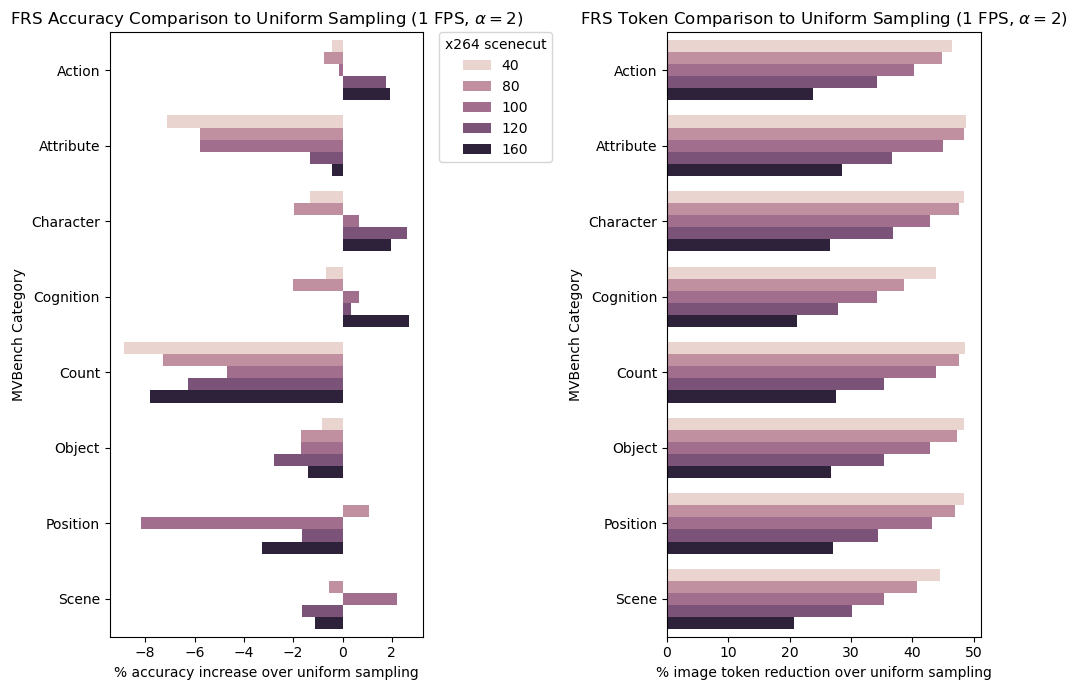

In [26]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 2,figsize=(10, 7))
sns.barplot(data=kf_cat, y='spatial_category', x='correct_percent_change', hue='scenecut', ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="x264 scenecut")
ax[0].set_title("FRS Accuracy Comparison to Uniform Sampling (1 FPS, $\\alpha=2$)")
ax[0].set_xlabel("% accuracy increase over uniform sampling")
ax[0].set_ylabel("MVBench Category")

sns.barplot(data=kf_cat, y='spatial_category', x='token_reduction_percent', hue='scenecut', legend=False, ax=ax[1])
ax[1].set_title("FRS Token Comparison to Uniform Sampling (1 FPS, $\\alpha=2$)")
ax[1].set_xlabel("% image token reduction over uniform sampling")
ax[1].set_ylabel("MVBench Category")

fig.tight_layout()
fig.savefig("mvbench_acc_combined_new.png", bbox_inches="tight")
plt.show()


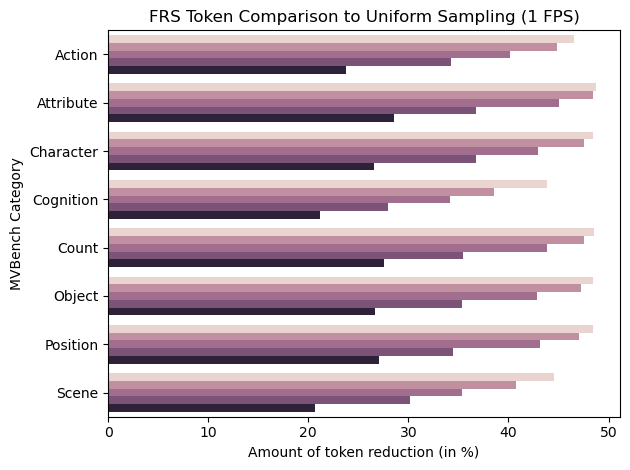

In [25]:
sns.barplot(data=kf_cat, y='spatial_category', x='token_reduction_percent', hue='scenecut', legend=False)
plt.tight_layout()
plt.title("FRS Token Comparison to Uniform Sampling (1 FPS)")
plt.xlabel("Amount of token reduction (in %)")
plt.ylabel("MVBench Category")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="x264 scenecut")
plt.tight_layout()
plt.savefig("mvbench_tokenusage.png")
plt.show()


In [27]:
targets = [8, 12, 16]

unif_dfs = []
x264_dfs = []
diffs = []
ratios = []

unif_cat_dfs = []
x264_cat_dfs = []
cat_diffs = []
cat_ratios = []

def agg_stats(group):
    return pd.Series(
        [group.correct.mean()],
        index=["correct"]
    )

for i, t in enumerate(targets):
    b = pd.read_json(f"evals/target_sampling/mvbench_frames={t}_uniform.json").groupby("category")[["correct"]].apply(agg_stats)
    unif_dfs.append(b.copy())
    k = pd.read_json(f"evals/target_sampling/mvbench_frames={t}.json").groupby("category")[["correct"]].apply(agg_stats)
    x264_dfs.append(k.copy())
    diffs.append((k["correct"] - b["correct"]) * 100)
    ratios.append(diffs[i] / (unif_dfs[i]["correct"]))
    
    b = b.reset_index()
    b["category"] = b.category.astype('category')
    b["spatial_category"] = b.category.map(cat_map).astype("category")
    b = b.groupby("spatial_category", observed=True)[["correct"]].apply(agg_stats)

    k = k.reset_index()
    k["category"] = k.category.astype('category')
    k["spatial_category"] = k.category.map(cat_map).astype("category")
    k = k.groupby("spatial_category", observed=True)[["correct"]].apply(agg_stats)
    
    unif_cat_dfs.append(b.copy())
    x264_cat_dfs.append(k.copy())
    
    cat_diffs.append((k["correct"] - b["correct"]) * 100)
    # print((k["correct"] - b["correct"]) * 100)
    cat_ratios.append(cat_diffs[i] / (unif_cat_dfs[i]["correct"]))
    

In [28]:
avg_ratio = sum(ratios) / 3
avg_cat_ratio = sum(cat_ratios) / 3

In [29]:
avg_ratio.sort_values().reset_index()

,category,correct
0,Action Localization,-20.071610
1,Object Interaction,-8.520622
2,Egocentric Navigation,-6.889824
3,Action Sequence,-5.517901
4,Character Order,-5.415502
5,Counterfactual Inference,-4.770512
6,Action Antonym,-1.196402
7,State Change,-0.977158
8,Episodic Reasoning,-0.737379
9,Unexpected Action,-0.557121


In [30]:
best_worst_subcat = avg_ratio.loc[["Action Count", "Action Prediction", "Moving Count", "Egocentric Navigation", "Object Interaction", "Action Localization"]]

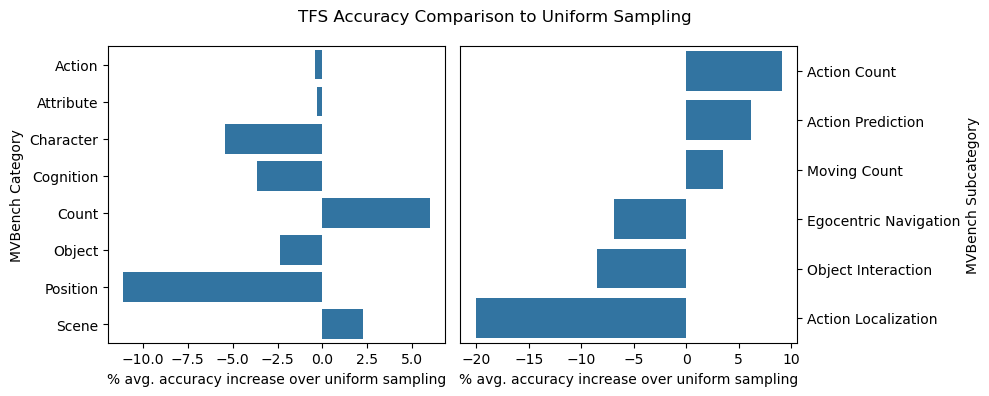

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=avg_cat_ratio.reset_index(), x='correct', y='spatial_category', ax=ax[0])
ax[0].set_ylabel("MVBench Category")
ax[0].set_xlabel("% avg. accuracy increase over uniform sampling")

sns.barplot(data=best_worst_subcat.reset_index(), x='correct', y='category', ax=ax[1])
ax[1].set_ylabel("MVBench Subcategory")
ax[1].set_xlabel("% avg. accuracy increase over uniform sampling")
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")


fig.suptitle("TFS Accuracy Comparison to Uniform Sampling")

fig.tight_layout()
fig.savefig("tfs_acc_combined.png", bbox_inches="tight")


In [33]:
u = pd.read_json(f"evals/target_sampling/mvbench_frames=8_uniform.json")
n = pd.read_json(f"evals/target_sampling/mvbench_frames=8.json")



In [37]:
u = u[u.category == "Action Localization"]
n = n[n.category == "Action Localization"]


In [44]:
n[u.correct & ~n.correct]

,video,category,qid,question,candidates,answer_gt,answer_pred,correct,token_count,frame_count
1801,data/MVBench/video/sta/sta_video/TS2DM.mp4,Action Localization,1,Can you identify when the action 'person still...,"[Throughout the entire video., At the beginnin...",Throughout the entire video.,(D),False,2064,8
1802,data/MVBench/video/sta/sta_video/ZNQVC.mp4,Action Localization,2,"In the given video, when does the action 'a pe...","[In the middle of the video., Throughout the e...",Throughout the entire video.,(C),False,2064,8
1806,data/MVBench/video/sta/sta_video/TKAUR.mp4,Action Localization,6,When in the video sequence do we observe the a...,"[In the middle of the video., At the beginning...",Throughout the entire video.,(B),False,2064,8
1815,data/MVBench/video/sta/sta_video/LQMXW.mp4,Action Localization,15,At what moment in the video does the action 'a...,"[At the end of the video., In the middle of th...",Throughout the entire video.,(D),False,2064,8
1820,data/MVBench/video/sta/sta_video/0TKKR.mp4,Action Localization,20,During which part of the video does the action...,"[At the end of the video., Throughout the enti...",Throughout the entire video.,(C),False,2064,8
1826,data/MVBench/video/sta/sta_video/V1WN7.mp4,Action Localization,26,During which part of the video does the action...,"[At the beginning of the video., At the end of...",Throughout the entire video.,(A),False,2064,8
1833,data/MVBench/video/sta/sta_video/TDAY1.mp4,Action Localization,33,"In the given video, when does the action 'pers...","[In the middle of the video., At the end of th...",Throughout the entire video.,(D),False,2064,8
1853,data/MVBench/video/sta/sta_video/HHNTA.mp4,Action Localization,53,When in the video sequence do we observe the a...,"[Throughout the entire video., At the end of t...",At the end of the video.,(D),False,2064,8
1857,data/MVBench/video/sta/sta_video/2ZICJ.mp4,Action Localization,57,"In the given video, when does the action 'pers...","[At the beginning of the video., In the middle...",At the end of the video.,(A),False,2064,8
1871,data/MVBench/video/sta/sta_video/IKJGO.mp4,Action Localization,71,"In the given video, when does the action 'the ...","[Throughout the entire video., At the beginnin...",At the end of the video.,(D),False,2064,8


In [171]:
n.loc[1925].candidates

['In the middle of the video.',
 'At the beginning of the video.',
 'At the end of the video.',
 'Throughout the entire video.']

In [71]:
from keyframes import X264Sampler
from utils import get_frames
from pathlib import Path

In [103]:
sampler = X264Sampler(target_frames=8)
path = Path("data/MVBench/video/sta/sta_video/NKE77.mp4")
start = 1.6
end = 21.4

In [104]:
frames_h264 = sampler.solve(path, start=start, end=end)["keyframes"]

In [105]:
frames_unif = sampler.uniform(path, start=start, end=end)

8 8
8 8


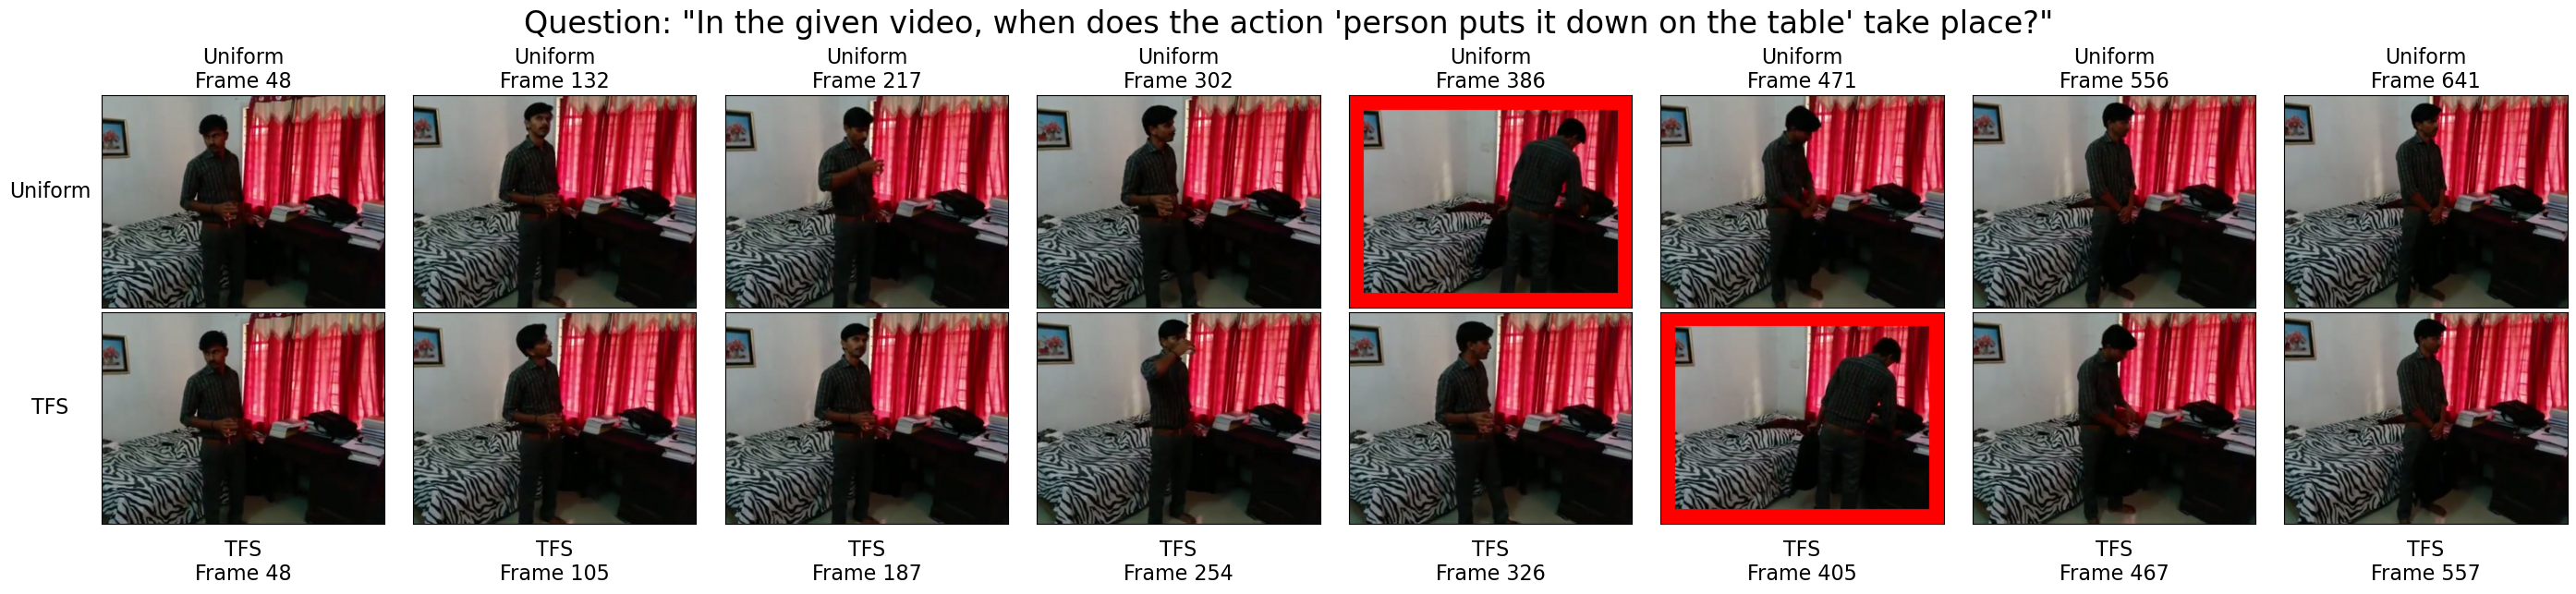

In [177]:
compare_sampled_frames(path, frames_unif, frames_h264)

In [176]:
import matplotlib.image as mpimg

def compare_sampled_frames(video_path, idx_unif, idx_h264):
    uniform_frames = get_frames(video_path, frames_unif)
    h264_frames = get_frames(video_path, frames_h264)

    n_uniform = len(idx_unif)
    n_h264 = len(idx_h264)
    n_cols = max(n_uniform, n_h264)

    print(n_uniform, n_h264)
    print(len(uniform_frames), len(h264_frames))
    
    fig, axes = plt.subplots(2, n_cols, figsize=(3.5 * n_cols, 6))
    
    plt.suptitle(f"Question: \"In the given video, when does the action 'person puts it down on the table' take place?\"\n", fontsize=24)

    for i in range(n_cols):
        ax = axes[0, i]
        if i < n_uniform:
            idx = int(idx_unif[i])
            img = mpimg.imread(uniform_frames[i])
            if i == 4:
                h, w, c = img.shape
                red = np.ones(img.shape).astype(np.int32)
                red *= [255, 0, 0]
                red[40:h-40, 40:w-40] = img[40:h-40, 40:w-40]
                img = red
            ax.imshow(img)
            ax.set_title(f"Uniform\nFrame {idx}", fontsize=16)
        else:
            ax.axis('off')
        
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0: ax.set_ylabel("Uniform", fontsize=16, rotation=0, labelpad=40)

    for i in range(n_cols):
        ax = axes[1, i]
        if i < n_h264:
            idx = int(idx_h264[i])
            img = mpimg.imread(h264_frames[i])
            if i == 5:
                h, w, c = img.shape
                red = np.ones(img.shape).astype(np.int32)
                red *= [255, 0, 0]
                red[40:h-40, 40:w-40] = img[40:h-40, 40:w-40]
                img = red
            ax.imshow(img)
            ax.set_title(f"TFS\nFrame {idx}", fontsize=16, y=-0.3)
        else:
            ax.axis('off')
            
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0: ax.set_ylabel("TFS", fontsize=16, rotation=0, labelpad=40)
    fig.tight_layout(pad=0, w_pad=0, h_pad=3.0)
    # plt.subplots_adjust(wspace=0)
    fig.savefig("frame_comparison_tfs.png", bbox_inches="tight")
    plt.show()
    # Delete temp files
    if not path.is_dir():
        for f in uniform_frames:
            Path(f).unlink()
        for f in h264_frames:
            Path(f).unlink()

In [216]:
acronyms = {i: "".join(list(map(lambda x: x[0], i.split(" ")))) for k in mvbench_categories.values() for i in k}

In [217]:
targets = [8, 12, 16]

def agg_stats(group):
    return pd.Series(
        [group.correct.mean() * 100],
        index=["correct"]
    )

out_table = None

for i, t in enumerate(targets):
    b = pd.read_json(f"evals/target_sampling/mvbench_frames={t}_uniform.json").groupby("category")[["correct"]].apply(agg_stats)
    k = pd.read_json(f"evals/target_sampling/mvbench_frames={t}.json").groupby("category")[["correct"]].apply(agg_stats)
    b = b.reset_index()
    k = k.reset_index()
    
    b["category"] = b.category.astype('category').map(acronyms)
    b["Sampling method"] = f"Uniform, N = {t}"
    k["category"] = k.category.astype('category').map(acronyms)
    k["Sampling method"] = f"TFS, N = {t}"

    b = b.pivot(index="Sampling method", columns="category", values="correct")
    k = k.pivot(index="Sampling method", columns="category", values="correct")

    if i == 0:
        out_table = b
    else:
        out_table = pd.concat([out_table, b], axis=0)
    out_table = pd.concat([out_table, k], axis=0)
out_table["Avg."] = out_table.mean(axis=1).round(decimals=1)
out_table = out_table[["Avg.", *[i for i in acronyms.values()]]]
out_table

category,Avg.,AA,AP,AS,FA,UA,OE,OI,OS,MD,AL,ST,AC,MC,MA,SC,CO,EN,ER,CI
Sampling method,,,,,,,,,,,,,,,,,,,,
"Uniform, N = 8",60.0,83.5,66.5,68.5,49.0,82.5,67.0,74.5,33.5,42.5,47.0,89.0,42.0,54.5,61.0,51.5,76.5,38.5,64.5,48.5
"TFS, N = 8",58.4,82.0,65.0,64.5,47.5,80.0,67.0,68.0,36.0,41.0,38.5,92.0,45.0,53.5,59.0,50.0,74.5,34.0,63.0,48.5
"Uniform, N = 12",59.9,83.5,62.5,70.0,49.0,79.5,65.0,77.0,37.0,38.5,49.0,90.0,42.0,52.5,62.5,51.0,78.5,38.5,64.5,47.5
"TFS, N = 12",59.1,81.5,68.0,64.5,48.5,82.0,67.0,69.5,34.5,39.5,40.0,91.5,47.5,57.0,64.0,50.5,74.5,34.5,63.0,45.5
"Uniform, N = 16",60.0,83.0,63.0,70.0,46.5,84.0,63.0,77.5,35.0,42.5,50.5,90.5,42.0,52.5,59.5,52.0,82.0,35.5,61.5,49.5
"TFS, N = 16",59.6,83.5,70.5,68.0,48.5,82.5,65.5,72.0,37.5,42.5,38.5,92.0,45.0,54.5,60.5,52.5,75.0,36.0,63.0,44.5


In [200]:
acronyms = {i: "".join(list(map(lambda x: x[0], i.split(" ")))) for k in mvbench_categories.values() for i in k}

,Sampling method,AA,AP,AS,FA,UA,OE,OI,OS,MD,AL,ST,AC,MC,MA,SC,CO,EN,ER,CI


In [210]:
out_table["Avg."] = out_table.mean(axis=1).round(decimals=1)

In [214]:
out_table = out_table[["Avg.", *[i for i in acronyms.values()]]]

category,Avg.,AA,AP,AS,FA,UA,OE,OI,OS,MD,AL,ST,AC,MC,MA,SC,CO,EN,ER,CI
Sampling method,,,,,,,,,,,,,,,,,,,,
"Uniform, N = 8",60.0,83.5,66.5,68.5,49.0,82.5,67.0,74.5,33.5,42.5,47.0,89.0,42.0,54.5,61.0,51.5,76.5,38.5,64.5,48.5
"TFS, N = 8",58.4,82.0,65.0,64.5,47.5,80.0,67.0,68.0,36.0,41.0,38.5,92.0,45.0,53.5,59.0,50.0,74.5,34.0,63.0,48.5
"Uniform, N = 12",59.9,83.5,62.5,70.0,49.0,79.5,65.0,77.0,37.0,38.5,49.0,90.0,42.0,52.5,62.5,51.0,78.5,38.5,64.5,47.5
"TFS, N = 12",59.1,81.5,68.0,64.5,48.5,82.0,67.0,69.5,34.5,39.5,40.0,91.5,47.5,57.0,64.0,50.5,74.5,34.5,63.0,45.5
"Uniform, N = 16",60.0,83.0,63.0,70.0,46.5,84.0,63.0,77.5,35.0,42.5,50.5,90.5,42.0,52.5,59.5,52.0,82.0,35.5,61.5,49.5
"TFS, N = 16",59.6,83.5,70.5,68.0,48.5,82.5,65.5,72.0,37.5,42.5,38.5,92.0,45.0,54.5,60.5,52.5,75.0,36.0,63.0,44.5


In [218]:
baseline_df = pd.read_json("evals/frame_reduction/mvbench_baseline.json")

In [236]:
unif = baseline_df.groupby("category")[["correct"]].apply(agg_stats).reset_index()
unif["category"] = unif["category"].astype('category').map(acronyms)
unif["Sampling method"] = "Uniform sampling"
unif = unif.pivot(index="Sampling method", columns="category", values="correct")

scenecuts = [40, 80, 100, 120, 160]
for sc in scenecuts:
    df = pd.read_json(f"evals/frame_reduction/mvbench_sc={sc}.json").groupby("category")[["correct"]].apply(agg_stats).reset_index()
    df["category"] = df["category"].astype('category').map(acronyms)
    df["Sampling method"] = f"FRS, scenecut = {sc}"
    df = df.pivot(index="Sampling method", columns="category", values="correct")
    unif = pd.concat([unif, df])

unif["Avg."] = unif.mean(axis=1).round(decimals=1)
unif = unif[["Avg.", *[i for i in acronyms.values()]]]

category,AA,AC,AL,AP,AS,CO,CI,EN,ER,FA,MA,MC,MD,OE,OI,OS,ST,SC,UA
Sampling method,,,,,,,,,,,,,,,,,,,
Uniform sampling,78.0,45.5,49.0,58.0,68.5,76.0,47.0,36.5,64.5,51.0,60.5,50.5,43.0,64.5,77.0,38.0,91.0,52.0,82.5
"FRS, scenecut = 40",78.0,38.0,49.5,59.0,68.0,75.0,44.5,36.0,66.5,50.0,56.0,49.5,42.5,63.0,77.0,38.0,91.0,48.5,81.5
"FRS, scenecut = 80",75.5,40.0,50.5,61.5,67.5,74.5,44.5,35.5,65.0,50.5,56.0,49.0,42.5,63.5,76.5,36.5,90.5,50.0,80.5
"FRS, scenecut = 100",76.5,44.0,46.5,61.5,67.5,76.5,46.0,37.0,66.0,49.5,53.0,47.5,38.0,62.0,78.0,36.5,93.0,53.0,82.5
"FRS, scenecut = 120",73.5,42.5,50.0,64.0,73.0,78.0,46.0,40.5,62.0,51.0,60.0,47.5,40.5,66.0,76.0,32.5,89.5,51.0,82.5
"FRS, scenecut = 160",75.5,40.5,48.5,64.5,71.0,77.5,50.5,38.5,63.0,50.5,59.5,48.0,40.5,65.5,78.0,33.5,90.0,52.5,83.0


In [237]:
print(unif.to_latex(float_format="{:.1f}".format))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
category & Avg. & AA & AP & AS & FA & UA & OE & OI & OS & MD & AL & ST & AC & MC & MA & SC & CO & EN & ER & CI \\
Sampling method &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Uniform sampling & 59.6 & 78.0 & 58.0 & 68.5 & 51.0 & 82.5 & 64.5 & 77.0 & 38.0 & 43.0 & 49.0 & 91.0 & 45.5 & 50.5 & 60.5 & 52.0 & 76.0 & 36.5 & 64.5 & 47.0 \\
FRS, scenecut = 40 & 58.5 & 78.0 & 59.0 & 68.0 & 50.0 & 81.5 & 63.0 & 77.0 & 38.0 & 42.5 & 49.5 & 91.0 & 38.0 & 49.5 & 56.0 & 48.5 & 75.0 & 36.0 & 66.5 & 44.5 \\
FRS, scenecut = 80 & 58.4 & 75.5 & 61.5 & 67.5 & 50.5 & 80.5 & 63.5 & 76.5 & 36.5 & 42.5 & 50.5 & 90.5 & 40.0 & 49.0 & 56.0 & 50.0 & 74.5 & 35.5 & 65.0 & 44.5 \\
FRS, scenecut = 100 & 58.7 & 76.5 & 61.5 & 67.5 & 49.5 & 82.5 & 62.0 & 78.0 & 36.5 & 38.0 & 46.5 & 93.0 & 44.0 & 47.5 & 53.0 & 53.0 & 76.5 & 37.0 & 66.0 & 46.0 \\
FRS, scenecut = 120 & 59.3 & 73.5 & 64.0 & 73.0 & 51.0 & 82.5 & 66.0 & 76.0 & 32.5 & 40.5 & 50.0 & 89.5

In [238]:
print(out_table.to_latex(float_format="{:.1f}".format))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
category & Avg. & AA & AP & AS & FA & UA & OE & OI & OS & MD & AL & ST & AC & MC & MA & SC & CO & EN & ER & CI \\
Sampling method &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Uniform, N = 8 & 60.0 & 83.5 & 66.5 & 68.5 & 49.0 & 82.5 & 67.0 & 74.5 & 33.5 & 42.5 & 47.0 & 89.0 & 42.0 & 54.5 & 61.0 & 51.5 & 76.5 & 38.5 & 64.5 & 48.5 \\
TFS, N = 8 & 58.4 & 82.0 & 65.0 & 64.5 & 47.5 & 80.0 & 67.0 & 68.0 & 36.0 & 41.0 & 38.5 & 92.0 & 45.0 & 53.5 & 59.0 & 50.0 & 74.5 & 34.0 & 63.0 & 48.5 \\
Uniform, N = 12 & 59.9 & 83.5 & 62.5 & 70.0 & 49.0 & 79.5 & 65.0 & 77.0 & 37.0 & 38.5 & 49.0 & 90.0 & 42.0 & 52.5 & 62.5 & 51.0 & 78.5 & 38.5 & 64.5 & 47.5 \\
TFS, N = 12 & 59.1 & 81.5 & 68.0 & 64.5 & 48.5 & 82.0 & 67.0 & 69.5 & 34.5 & 39.5 & 40.0 & 91.5 & 47.5 & 57.0 & 64.0 & 50.5 & 74.5 & 34.5 & 63.0 & 45.5 \\
Uniform, N = 16 & 60.0 & 83.0 & 63.0 & 70.0 & 46.5 & 84.0 & 63.0 & 77.5 & 35.0 & 42.5 & 50.5 & 90.5 & 42.0 & 52.5 & 59.5 & 5